In [1]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path

import matplotlib as mpl
import numpy as np
import pandas as pd
import requests
import xarray as xr

from oslofjord.regrid import regrid_from_norkyst

In [2]:
OPENDAP_URL = "https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m/"
CATALOG_URL = "https://thredds.met.no/thredds/catalog/fou-hi/norkyst800m/catalog.xml"
PARAMETERS = ["temperature", "salinity", "u_eastward", "v_northward"]

### Data fetching
Download NorKyst data (ROMS model for the Norwegian coast).
This data will be used for the boundary conditions, which are set up as forcing.
Skip if you have it already.

In [ ]:
def list_opendap_files(base_url=CATALOG_URL):
    response = requests.get(base_url)

    if response.status_code != 200:
        print("Failed to retrieve the directory listing.")
        return []

    root = ET.fromstring(response.content)
    files = [
        elem.attrib["name"]
        for elem in root.findall(".//{http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0}dataset")
        if elem.attrib["name"].endswith(".nc")
    ]

    return files

In [ ]:
# names are like 20240101, so put an appropriate string to get specific files
month_string = "202403"
files = sorted([s for s in list_opendap_files() if month_string in s])
urls = [os.path.join(OPENDAP_URL, x) for x in files]
dss = [xr.open_dataset(url)[PARAMETERS] for url in urls]

In [ ]:
ds = xr.combine_by_coords(dss, combine_attrs="override")  # downloading, takes a while

In [ ]:
encoding = {var: {"zlib": True, "complevel": 5} for var in ds.data_vars}
ds.to_netcdf(
    os.path.join(Path.home(), "FjordsSim_data", "oslofjord", f"NorKyst-800m_ZDEPTHS_avg_{month_string}.nc"),
    encoding=encoding,
)

In [ ]:
del ds, dss, urls, files, encoding, month_string

### Regridding
Open the downloaded datasets and regrid them to the coordinates from a bathymetry file.

In [3]:
FILES = sorted(
    os.path.join(Path.home(), "FjordsSim_data", "oslofjord", f)
    for f in os.listdir(os.path.join(Path.home(), "FjordsSim_data", "oslofjord"))
    if f.startswith("NorKyst-800m_ZDEPTHS_avg_")
)

In [4]:
ds_grid = xr.open_dataset(os.path.join(Path.home(), "FjordsSim_data", "oslofjord", "bathymetry_105to232.nc"))

In [5]:
lat_diff = np.diff(ds_grid["lat"].values)[0]
lat_faces = np.zeros(shape=ds_grid["lat"].values.shape[0] + 1)
lat_faces[0] = ds_grid["lat"].values[0] - lat_diff / 2
lat_faces[1:] = ds_grid["lat"].values + lat_diff / 2

In [6]:
lon_diff = np.diff(ds_grid["lon"].values)[0]
lon_faces = np.zeros(shape=ds_grid["lon"].values.shape[0] + 1)
lon_faces[0] = ds_grid["lon"].values[0] - lon_diff / 2
lon_faces[1:] = ds_grid["lon"].values + lon_diff / 2

In [7]:
z_faces = ds_grid.z_faces.values
z_centers = [(z_faces[i] + z_faces[i + 1]) / 2 for i in range(len(z_faces) - 1)]
ds_out_c = xr.Dataset(
    {
        "lat": (["lat"], ds_grid["lat"].values, {"units": "degrees_north"}),
        "lon": (["lon"], ds_grid["lon"].values, {"units": "degrees_east"}),
    }
)
ds_out_u = xr.Dataset(
    {
        "lat": (["lat"], ds_grid["lat"].values, {"units": "degrees_north"}),
        "lon": (["lon"], lon_faces, {"units": "degrees_east"}),
    }
)
ds_out_v = xr.Dataset(
    {
        "lat": (["lat"], lat_faces, {"units": "degrees_north"}),
        "lon": (["lon"], ds_grid["lon"].values, {"units": "degrees_east"}),
    }
)

In [8]:
time_list = []
temp_list = []
salt_list = []
u_list = []
v_list = []

for file in FILES:
    ds_in = xr.open_dataset(file)
    np_time, np_temp, np_salt, np_u, np_v = regrid_from_norkyst(
        ds_in, ds_out_c, ds_out_u, ds_out_v, np.array(z_centers)
    )

    time_list.append(np_time)
    temp_list.append(np_temp)
    salt_list.append(np_salt)
    u_list.append(np_u)
    v_list.append(np_v)
    print(f"File {file} processed.")

File /home/sia/FjordsSim_data/oslofjord/NorKyst-800m_ZDEPTHS_avg_202401.nc processed.
File /home/sia/FjordsSim_data/oslofjord/NorKyst-800m_ZDEPTHS_avg_202402.nc processed.
File /home/sia/FjordsSim_data/oslofjord/NorKyst-800m_ZDEPTHS_avg_202403.nc processed.


In [9]:
np_time = np.concatenate(time_list, axis=0)
np_temp = np.concatenate(temp_list, axis=0).astype(np.float32)
np_salt = np.concatenate(salt_list, axis=0).astype(np.float32)
np_u = np.concatenate(u_list, axis=0).astype(np.float32)
np_v = np.concatenate(v_list, axis=0).astype(np.float32)

In [10]:
Tout_lambda = np.zeros_like(np_temp)
Sout_lambda = np.zeros_like(np_salt)
Uout_lambda = np.zeros_like(np_u)
Vout_lambda = np.zeros_like(np_v)

In [11]:
dsout = xr.Dataset(
    {
        "T": (["time", "Nz", "Ny", "Nx"], np_temp),
        "T_lambda": (["time", "Nz", "Ny", "Nx"], Tout_lambda),
        "S": (["time", "Nz", "Ny", "Nx"], np_salt),
        "S_lambda": (["time", "Nz", "Ny", "Nx"], Sout_lambda),
        "u": (["time", "Nz", "Ny", "Nx_faces"], np_u),
        "u_lambda": (["time", "Nz", "Ny", "Nx_faces"], Uout_lambda),
        "v": (["time", "Nz", "Ny_faces", "Nx"], np_v),
        "v_lambda": (["time", "Nz", "Ny_faces", "Nx"], Vout_lambda),
    },
    coords={
        "time": np_time,
        "Nz": z_centers,
        "Ny": ds_grid["lat"].values,
        "Ny_faces": lat_faces,
        "Nx": ds_grid["lon"].values,
        "Nx_faces": lon_faces,
    },
)

In [12]:
dsout

<xarray.Dataset> Size: 1GB
Dimensions:   (time: 90, Nz: 18, Ny: 232, Nx: 105, Nx_faces: 106, Ny_faces: 233)
Coordinates:
  * time      (time) datetime64[ns] 720B 2024-01-01T12:00:00 ... 2024-03-31T1...
  * Nz        (Nz) float64 144B -425.0 -375.0 -325.0 -275.0 ... -2.5 -1.5 -0.5
  * Ny        (Ny) float64 2kB 59.0 59.0 59.01 59.01 ... 59.92 59.92 59.93 59.93
  * Nx        (Nx) float64 840B 10.2 10.21 10.22 10.22 ... 11.0 11.0 11.01 11.02
  * Nx_faces  (Nx_faces) float64 848B 10.2 10.2 10.21 ... 11.01 11.02 11.02
  * Ny_faces  (Ny_faces) float64 2kB 59.0 59.0 59.01 59.01 ... 59.92 59.93 59.93
Data variables:
    T         (time, Nz, Ny, Nx) float32 158MB nan nan nan nan ... nan nan nan
    T_lambda  (time, Nz, Ny, Nx) float32 158MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    S         (time, Nz, Ny, Nx) float32 158MB nan nan nan nan ... nan nan nan
    S_lambda  (time, Nz, Ny, Nx) float32 158MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u         (time, Nz, Ny, Nx_faces) float32 159MB nan nan nan ... nan nan nan
    u_lambda  (time, Nz, Ny, Nx_faces) float32 159MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v         (time, Nz, Ny_faces, Nx) float32 159MB nan nan nan ... nan nan nan
    v_lambda  (time, Nz, Ny_faces, Nx) float32 159MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [13]:
z_level = -1

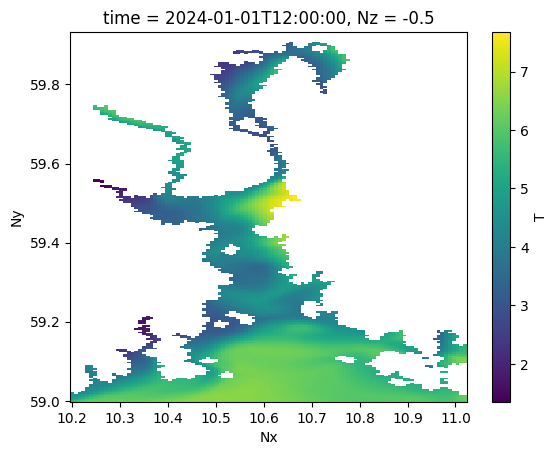

In [14]:
dsout.T.isel(time=0, Nz=z_level).plot()

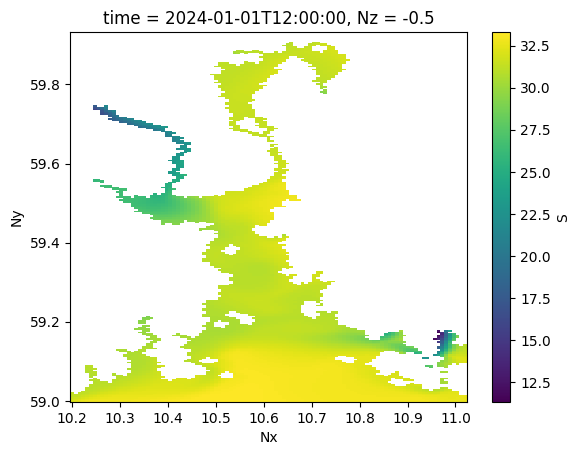

In [15]:
dsout.S.isel(time=0, Nz=z_level).plot()

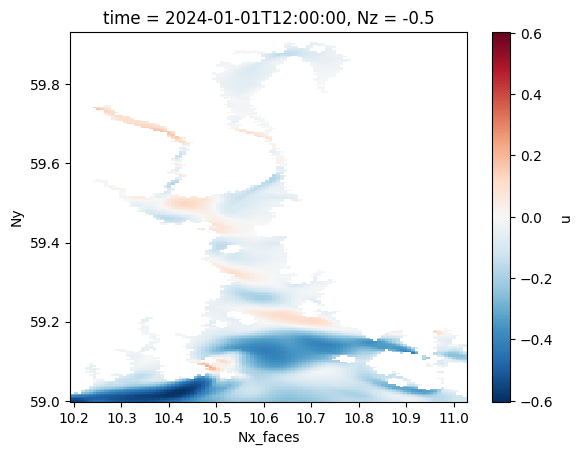

In [16]:
dsout.u.isel(time=0, Nz=z_level).plot()

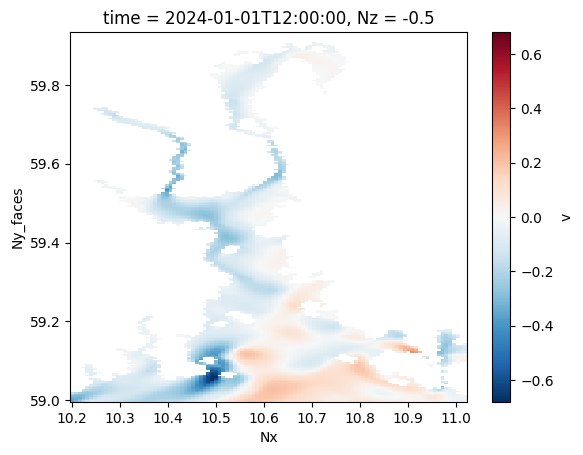

In [17]:
dsout.v.isel(time=0, Nz=z_level).plot()

### Prepare the forcing dataset
add Lambda values for boundaries, add rivers, etc.

In [18]:
ds = dsout.copy(deep=True)

In [19]:
np_z_centers = (ds_grid.z_faces.values[:-1] + ds_grid.z_faces.values[1:]) / 2
oy, ox, oz = (value for value in ds_grid.sizes.values())
np_mask = (np_z_centers > ds_grid.h.values[..., np.newaxis]).astype(int).transpose(2, 0, 1)

In [20]:
np_mask_u = np.zeros((oz - 1, oy, ox + 1))
np_mask_u[:, :, :-1] = np_mask
np_mask_u[:, :, 1:] = np.where(np_mask_u[:, :, 1:] == 0, np_mask, np_mask_u[:, :, 1:])

In [21]:
np_mask_v = np.zeros((oz - 1, oy + 1, ox))
np_mask_v[:, :-1, :] = np_mask
np_mask_v[:, 1:, :] = np.where(np_mask_v[:, 1:, :] == 0, np_mask, np_mask_v[:, 1:, :])

There are some data gaps in the downloaded datasets

In [22]:
new_time = pd.date_range(start=ds.time[0].values, end=ds.time[-1].values, freq="D")

In [23]:
new_time[~new_time.isin(ds.time.values)]  # this shows which dates are missing in the original data

DatetimeIndex(['2024-02-29 12:00:00'], dtype='datetime64[ns]', freq='D')

In [24]:
ds = ds.reindex(time=new_time, method="ffill")

Fill in lambdas for the sourthern boundary conditions.
Lambdas that -1 < lambda < 1 are relaxation rates.
Lambdas > 2 mean flux in x direction (west to east).
Lambdas < -1 mean flux in y direction (south to north).

In [25]:
southern_edge = 10  # use relaxation at 10 southernmost 'layers' at all depths
lambda_relaxation = 1 / (60 * 60 * 24)

In [26]:
ds["T_lambda"][:, :, :southern_edge, :] = (lambda_relaxation) * np_mask[:, :southern_edge, :]
ds["T_lambda"] = ds["T_lambda"].astype(np.float32)
ds["S_lambda"][:, :, :southern_edge, :] = (lambda_relaxation) * np_mask[:, :southern_edge, :]
ds["S_lambda"] = ds["S_lambda"].astype(np.float32)
ds["u_lambda"][:, :, :southern_edge, :] = (lambda_relaxation) * np_mask_u[:, :southern_edge, :]
ds["u_lambda"] = ds["u_lambda"].astype(np.float32)
ds["v_lambda"][:, :, :southern_edge, :] = (lambda_relaxation) * np_mask_v[:, :southern_edge, :]
ds["v_lambda"] = ds["v_lambda"].astype(np.float32)

Add rivers

In [27]:
# Drammenselva
ds["S"].values[:, -2:, 186, 8] = 0
ds["S_lambda"].values[:, -2:, 186, 8] = 1 / (60 * 60)
ds["v"].values[:, -2:, 187, 8] = -0.5  # negative flux means 'to the south'
ds["v_lambda"].values[:, -2:, 187, 8] = -2  # this lambda means flux in 'y' direction

In [28]:
# Barumsbassenget
y, x = 218, 42
ds["S"].values[:, -2:, y, x] = 0
ds["S_lambda"].values[:, -2:, y, x] = 1 / (60 * 60)
ds["u"].values[:, -2:, y, x] = 0.5  # to the east
ds["u_lambda"].values[:, -2:, y, x] = 2  # x direction

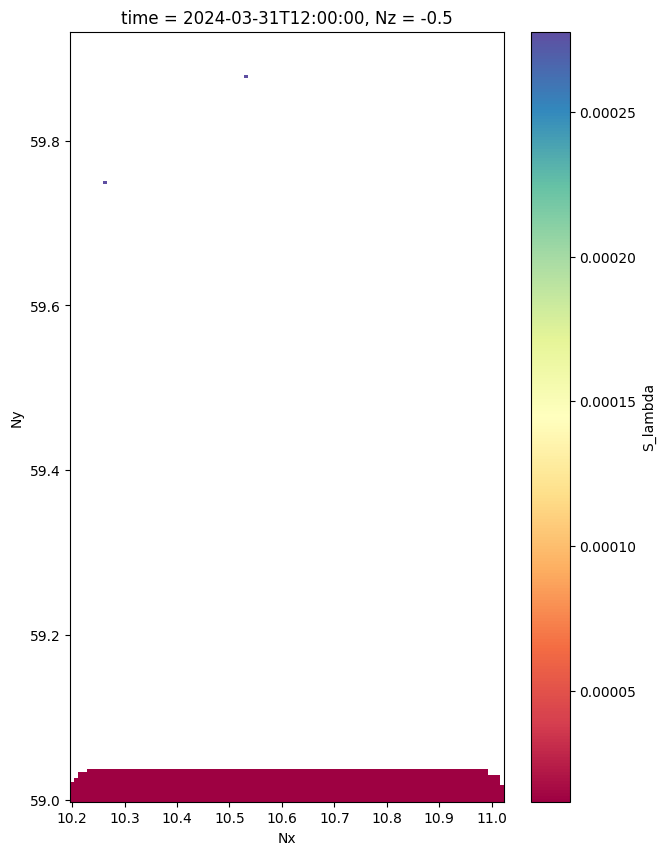

In [29]:
ds.S_lambda.isel(time=-1, Nz=-1).where(lambda x: x != 0).plot(cmap=mpl.colormaps.get_cmap("Spectral"), figsize=(7, 10))

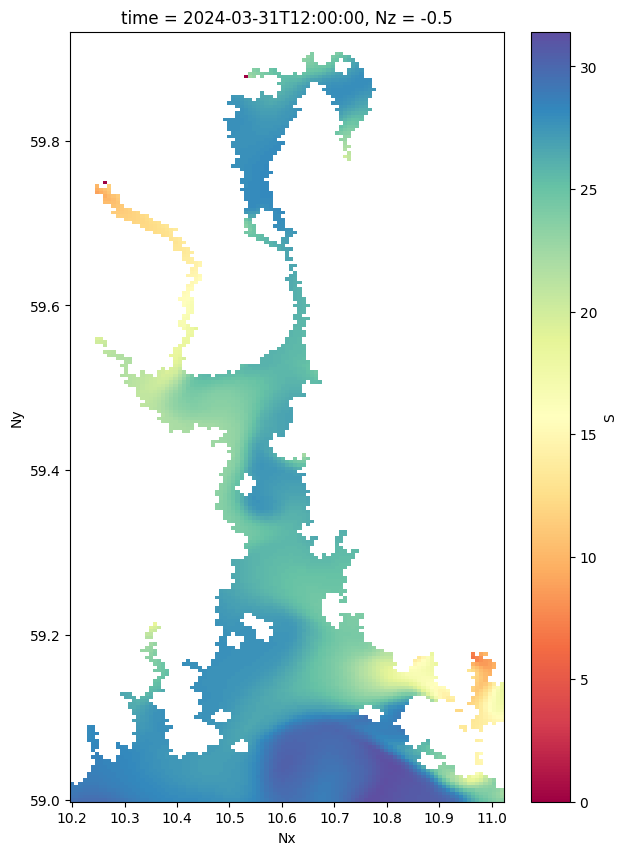

In [30]:
ds.S.isel(time=-1, Nz=-1).plot(cmap=mpl.colormaps.get_cmap("Spectral"), figsize=(7, 10))

In [31]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:   (time: 91, Nz: 18, Ny: 232, Ny_faces: 233, Nx: 105, Nx_faces: 106)
Coordinates:
  * time      (time) datetime64[ns] 728B 2024-01-01T12:00:00 ... 2024-03-31T1...
  * Nz        (Nz) float64 144B -425.0 -375.0 -325.0 -275.0 ... -2.5 -1.5 -0.5
  * Ny        (Ny) float64 2kB 59.0 59.0 59.01 59.01 ... 59.92 59.92 59.93 59.93
  * Ny_faces  (Ny_faces) float64 2kB 59.0 59.0 59.01 59.01 ... 59.92 59.93 59.93
  * Nx        (Nx) float64 840B 10.2 10.21 10.22 10.22 ... 11.0 11.0 11.01 11.02
  * Nx_faces  (Nx_faces) float64 848B 10.2 10.2 10.21 ... 11.01 11.02 11.02
Data variables:
    T         (time, Nz, Ny, Nx) float32 160MB nan nan nan nan ... nan nan nan
    T_lambda  (time, Nz, Ny, Nx) float32 160MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    S         (time, Nz, Ny, Nx) float32 160MB nan nan nan nan ... nan nan nan
    S_lambda  (time, Nz, Ny, Nx) float32 160MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u         (time, Nz, Ny, Nx_faces) float32 161MB nan nan nan ... nan nan nan
    u_lambda  (time, Nz, Ny, Nx_faces) float32 161MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v         (time, Nz, Ny_faces, Nx) float32 160MB nan nan nan ... nan nan nan
    v_lambda  (time, Nz, Ny_faces, Nx) float32 160MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

Save

In [32]:
encoding = {var: {"zlib": True, "complevel": 5} for var in ds.data_vars}
ds.fillna(-999).to_netcdf(
    os.path.join(Path.home(), "FjordsSim_data", "oslofjord", "forcing_105to232.nc"),
    encoding=encoding,
)